# Basic Neural Simulation with NeuroWorkflow

This notebook demonstrates how to create a simple neural simulation workflow using the NeuroWorkflow library. We'll build a workflow that:

1. Creates a neural network from SONATA format
2. Simulates the network using NEST

## Setup

First, let's make sure we can import the NeuroWorkflow library. If you've installed it with pip, you can import it directly. Otherwise, we'll add the source directory to the Python path.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add the src directory to the Python path if needed
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import NeuroWorkflow components
from neuroworkflow import WorkflowBuilder
from neuroworkflow.nodes.network.BuildSonataNetworkNode import BuildSonataNetworkNode
from neuroworkflow.nodes.simulation.SimulateSonataNetworkNode import SimulateSonataNetworkNode


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Mar  4 2025 17:27:39

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Creating Nodes

Now, let's create the nodes for our workflow. We'll need:

1. A network builder node to create the neural network
2. A simulation node to run the simulation

In [2]:
# Create a network builder node
build_network = BuildSonataNetworkNode("SonataNetworkBuilder")

# Configure the network builder
build_network.configure(
    sonata_path="../data/300_pointneurons",  # Path to our SONATA configuration
    net_config_file="circuit_config.json",
    sim_config_file="simulation_config.json",
    hdf5_hyperslab_size=1024
)

# Print node information
print(build_network)

Node: SonataNetworkBuilder (network_builder)
Description: Loads SONATA configuration and builds a network in NEST
Parameters:
  sonata_path: ../data/300_pointneurons
  net_config_file: circuit_config.json
  sim_config_file: simulation_config.json
  hdf5_hyperslab_size: 1024
Output Ports:
  sonata_net (object, not connected): SONATA network object
  node_collections (dict, not connected): NEST node collections
Process Steps:
  initialize_environment: Initialize NEST environment
    Outputs: environment_initialized
  initialize_sonata: Initialize SONATA network
    Outputs: sonata_net
  build_network: Build network in NEST
    Inputs: sonata_net
    Outputs: node_collections


In [3]:
# Create a simulation node
simulate_network = SimulateSonataNetworkNode("SonataNetworkSimulation")

# Configure the simulation
simulate_network.configure(
    simulation_time=1000.0,  # Simulation time in milliseconds
    record_from_population="internal",
    record_n_neurons=40
)

# Print node information
print(simulate_network)

Node: SonataNetworkSimulation (simulation_node)
Description: Simulates a NEST network built from SONATA
Parameters:
  simulation_time: 1000.0
  record_from_population: internal
  record_n_neurons: 40
Input Ports:
  sonata_net (object, required, not connected): SONATA network object
  node_collections (dict, required, not connected): NEST node collections
Output Ports:
  simulation_completed (bool, not connected): Whether simulation completed successfully
  spike_recorder (object, not connected): NEST spike recorder device
Process Steps:
  initialize_recordables: Setup spike recorders
    Inputs: node_collections
    Outputs: spike_recorder
  simulate_sonata: Run simulation
    Inputs: sonata_net, node_collections, spike_recorder
    Outputs: simulation_completed


## Building the Workflow

Now that we have our nodes, let's build a workflow that connects them together.

In [4]:
# Create a workflow builder
workflow_builder = WorkflowBuilder("neural_simulation")

# Add nodes to the workflow
workflow_builder.add_node(build_network)
workflow_builder.add_node(simulate_network)

# Connect the nodes
# The output 'sonata_net' from the builder node connects to the input 'sonata_net' of the simulation node
workflow_builder.connect(
    "SonataNetworkBuilder", "sonata_net", 
    "SonataNetworkSimulation", "sonata_net"
)

# Connect node collections
workflow_builder.connect(
    "SonataNetworkBuilder", "node_collections", 
    "SonataNetworkSimulation", "node_collections"
)

# Build the workflow
workflow = workflow_builder.build()

# Print workflow information
print(workflow)

Workflow: neural_simulation
Nodes:
  SonataNetworkBuilder
  SonataNetworkSimulation
Connections:
  SonataNetworkBuilder.sonata_net -> SonataNetworkSimulation.sonata_net
  SonataNetworkBuilder.node_collections -> SonataNetworkSimulation.node_collections


## Executing the Workflow

Now let's execute the workflow and see the results.

Executing workflow...
Executing node: SonataNetworkBuilder
Initializing NEST environment
Initializing SONATA network from ../data/300_pointneurons
Building network using hdf5_hyperslab_size = 1024
Executing node: SonataNetworkSimulation
Creating spike recorder
SONATA network simulation for 1000.0 ms
Running NEST simulation for 1000.0 ms...
Simulation completed in 0.21 seconds


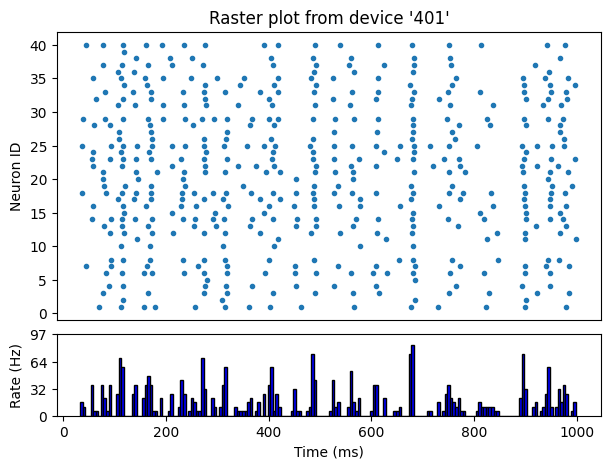


Workflow execution completed successfully!


In [5]:
# Execute the workflow
print("Executing workflow...")
success = workflow.execute()

if success:
    print("\nWorkflow execution completed successfully!")
else:
    print("\nWorkflow execution failed!")

## Accessing Results

After the workflow has executed, we can access the results from the output ports of the nodes.

In [6]:
# Get the spike recorder from the simulation node
spike_recorder = simulate_network.get_output_port("spike_recorder").value

# Print information about the spike recorder
print("Spike Recorder Information:")

# Check if we have spike events
print(f"\nRecorded {len(spike_recorder.events['times'])} spikes")
print(f"From {len(set(spike_recorder.events['senders']))} unique neurons")
print(f"Neuron IDs: {spike_recorder.events['senders']}")


Spike Recorder Information:

Recorded 478 spikes
From 38 unique neurons
Neuron IDs: [25 18 29  7 40 14 23 24 35 16 22 28 32  1  3 21 37 13 20 40 19 29 33  6
 18  4 12 23 28  7  8 14 25 17 31 36 27 26  1 35  6 10 18 24 37 13 14 22
 23 29 32  4  8 16 25 40  2 12 15 39 34 19 33 17 36 31 14 38 18 21 23 11
 25 20  1  6 35 16 40  7 34  3 13 29 37 24 28  8 10 17 18 19 27 32 33 23
  6 12 14 25 26  1 21 29 35 40 31 38 15 25 22 37 12 16 23 18 14 17 33  8
 20 40  6 21 31 19 25 29 35 38 28 13 18 14  1 16  7 29 37  3 25 26  8 12
 17 23 33  6 32 34 40  4 21 22 24 31  5 14 18 29 15 13 35  2 17 10 14 25
  1 12 33  8 21 18  4 26  7 29  3  6 23 27 16 22 31 34 19 35 25  1 28 13
 18  4 14 29 22 17 12 33 15 25 40  6 21  8 16 29 32  1 38 26 23 31 14 24
  3 37 18 10 22 28 34 25 29 35 11 33 40 17 21 16  6  7 13 18 20  4 14  1
 25 35 12 18 23 24 29 16 26 38 17 19 33 36  8 31  3 40 21 34 37 13 14  6
 22 32 35 18 25 23 27  4 29 21 19  7 16 12 40 37 31 22  6 18 38 25 33  3
 20 21  1 13 29 36 14 23 16 17 10  6  4 

## Visualizing the Workflow

Let's create a simple visualization of our workflow using NetworkX and Matplotlib.

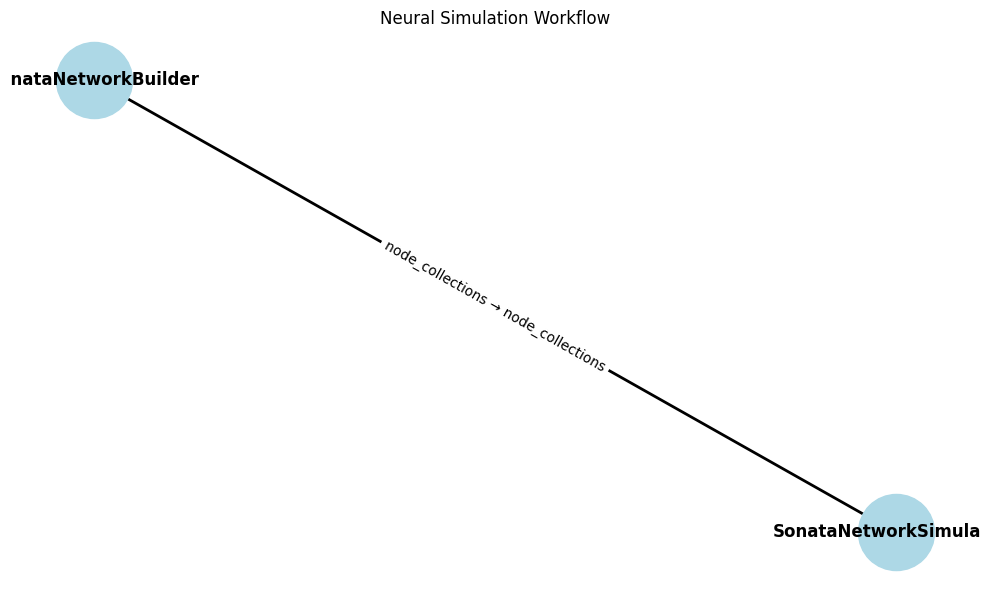

In [7]:
try:
    import networkx as nx
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for node_name in workflow.nodes:
        G.add_node(node_name)
    
    # Add edges for connections
    for conn in workflow.connections:
        G.add_edge(
            conn.from_node, 
            conn.to_node, 
            label=f"{conn.from_port} → {conn.to_port}"
        )
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=2, arrowsize=20)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    
    # Draw edge labels
    edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    plt.title("Neural Simulation Workflow")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("NetworkX not installed. Install with: pip install networkx")

## Conclusion

In this notebook, we've demonstrated how to:

1. Create nodes for network building and simulation
2. Configure the nodes with appropriate parameters
3. Build a workflow by connecting the nodes
4. Execute the workflow to simulate a neural network
5. Access the simulation results including spike data
6. Visualize the spike trains and firing rates
7. Visualize the workflow structure

This example shows the basic structure of a NeuroWorkflow for neural simulation. The workflow:

- Loads SONATA configuration files from the 300_pointneurons directory
- Builds a network with excitatory and inhibitory populations
- Simulates the network for a specified time period
- Records and visualizes spike activity

In more complex scenarios, you can add additional nodes for data loading, analysis, visualization, and more, as demonstrated in the other notebooks in this series.